# Classifying raster data

In the previous week, we produced some nice looking maps of Florence from remote sensing data. We computed some band indices and learnt that positive NDWI values were likely to be associated with water (e.g lakes, rivers, ocean). 

However, we did not conduct any quantitative analysis. For example, what if someone wanted to know how much water or sand was in the image? To do this, we would first have to classify pixels that are likely to be water using a threshold. In this week, we will learn how to do this, and other quantitative analysis, by combining raster and vector data. 

```{image} images/dune.jpg
:alt: dune
:class: bg-primary mb-1
:width: 600px
:align: center
```

In [75]:
# Import modules
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from scipy import stats
import glob
import matplotlib.pyplot as plt

## Preparing the data

In [76]:
# Define paths to data
raster = 'data/ndwi.tif'
shapefile = 'data/water.shp'

# Import raster data
src = rasterio.open(raster)
ndwi = src.read(1)

# Import shapefile
water = gpd.read_file(shapefile)

The `ndwi.tif` is a raster file of Florence, OR containing the NDWI values we produced last week. 

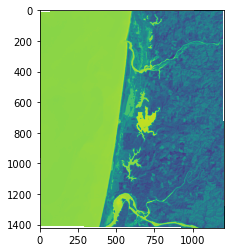

In [77]:
plt.imshow(ndwi)

The `water.shp` file is a shapefile containing some polygons. Each polygon outlines areas of known water in the Landsat image. This shapefile could be produced using manual digitization in ArcGIS or QGIS.

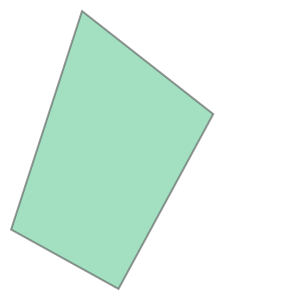

In [78]:
water.iloc[1].geometry

Before we can extract the NDWI values that intersect the polygons, we must check that the two datasets have the same coordinate reference system. Since they are both projected in **UTM Zone 10N (EPSG:32610)** we can move onto the next step.

In [79]:
src.crs

CRS.from_epsg(32610)

In [80]:
water.crs

<Derived Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Masking raster data using shapefile

`Rasterio` provides a function called [`mask.mask`](https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#) for masking raster data using polygons. This function has a few arguments. The first is the raster dataset (i.e. `src` in our case). The second argument is the shape to mask. In the docs, it notes that this shape shold be a format that implements the Python geo interface protocol (such as a Shapely Polygon). 

So we will have to specify only the **geometry** of our `GeoPandas` DataFrame, not the DataFrame object itself. The **Invert** argument determines whether pixels inside or outside shapes will be masked. The **nodata** argument allows us to set the no data value (i.e. values of pixels outside the mask).

In [81]:
water_mask, transform = mask(src, water.geometry, invert=False, nodata=np.nan)

The `mask.mask` function returns an array where pixel values inside the mask are retained, while pixel values outside the mask are assigned a NaN value. 

In [82]:
water_mask

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

## Determining a threshold

We can find the minimum, mean, and maximum value of pixels within the water mask using the following functions which **ignore NaN values** when computing statistics.

In [83]:
np.nanmin(water_mask), np.nanmean(water_mask), np.nanmax(water_mask)

(0.002352941176470588, 0.022482506867466456, 0.07258794424666626)

## Applying the threshold

Since we know that all values higher than the minimum NDWI value are likely to be water, we can use the minimum value to threshold our original image. Anything higher than the threshold will be classified as water, anything lower will be classified as non-water. We can do this using [`np.where`](https://numpy.org/doc/stable/reference/generated/numpy.where.html) which assigns all elements a value depending on a condition. Here we assign a value of 1 to pixels that fufill the condition, and value of 0 for pixels that don't.

In [84]:
classified = np.where(ndwi > np.nanmin(water_mask), 1, 0)

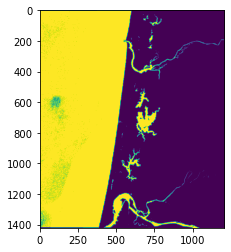

In [85]:
plt.imshow(classified)

We can compute the percentage of the image that is classified as water by dividing the sum of pixels classified as water by the total number of pixels. Note that since **non-water pixels** are classified as zero, we can just sum the values in the `classified` array. 

In [86]:
np.sum(classified) / np.size(classified)

0.44342335671240024

## Classify sand

Next we will classify the percentage of the image that is sand. When we first plotted the remote sensing image in [Week 9](../demos/09b-demo.ipynb), sand appeared very bright in the Band 1. First we will import a shapefile containing some sand values.

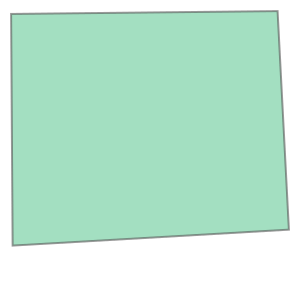

In [8]:
# Import shapefile
shapefile = 'data/sand.shp'
sand = gpd.read_file(shapefile)
sand.iloc[1].geometry

Next we will import the Red, Green, and Blue bands from the remote sensing image.

In [12]:
# Define list of Landsat bands
files = sorted(glob.glob('data/landsat/*.tif'))

# Read R, G, B bands
src_1 = rasterio.open(files[0])
band_1 = src_1.read(1)

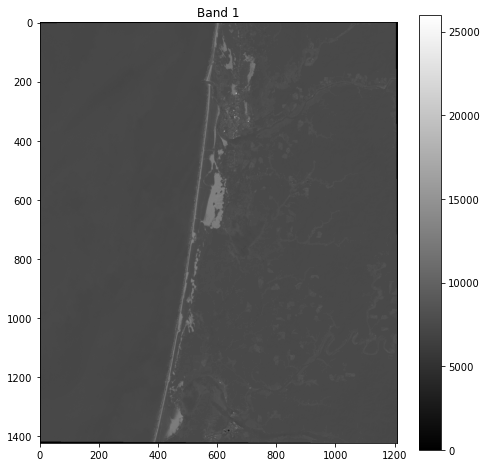

In [13]:
# Plot dataset
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(band_1, cmap='gray')
ax.set_title("Band 1")
fig.colorbar(im, orientation='vertical')
plt.show()

## Mask the data

In [66]:
sand_mask, transform = mask(src_1, sand.geometry, invert=False, nodata=0)

## Determine threshold 

Note that since our data type is not a `float` data type, we can't use `np.nan` as a no data value. So we will set our `nodata` value to `0` and mask out all values not equal (`!=`) to 0 before computing stats.

In [67]:
sand_mask[sand_mask != 0]

array([12912, 12952, 13027, 13065, 13027, 12980, 12838, 12976, 12865,
       12874, 12993, 12843, 12875, 12929, 12976, 12868, 12904, 12899,
       12843, 12822, 12833, 12851, 12793, 13029, 12740, 12695, 12846,
       12751, 12889, 12951, 12877, 12946, 12941, 12734, 12985, 13094,
       12949, 12921, 12788, 13007, 12966, 12775, 13030, 13017, 12997,
       13018, 12885, 12895, 12967, 12923, 12947, 13032, 13128, 13009,
       12976, 12973, 13030, 13022, 12916, 12937, 13145, 12819, 12818,
       12882, 12901, 13195, 12835, 13090, 12907, 13055, 12754, 13040,
       12923, 12943, 13151, 12906, 13100, 12796, 13263, 13005, 13070,
       13024, 13138, 13390, 12957, 12857, 12982, 13049, 12999, 13108,
       12974, 13148, 12933, 12705, 12837, 12880, 13141, 13098, 12954,
       12959, 12969, 13031, 13123, 13050, 13039, 12862, 12824, 12962,
       13042, 12989, 12912, 13037, 12979, 12839, 12800, 13076, 12759,
       12847, 12888, 13030, 13300, 13184, 13033, 12951, 12991, 13121,
       12789, 12772,

In [68]:
np.min(sand_mask[sand_mask != 0]), np.nanmean(sand_mask[sand_mask != 0]), np.nanmax(sand_mask[sand_mask != 0])

(12545, 12829.9375, 13390)

Now we can choose a threshold and classify our image.

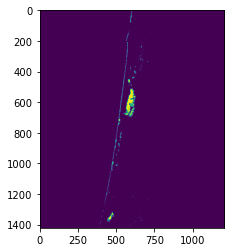

In [69]:
classified = np.where(band_1 > np.min(sand_mask[sand_mask != 0]), 1, 0)
plt.imshow(classified)

It looks like there is some sand in the lower of the image that was not classified as sand. This is probably because our threshold was too strict. Let's lower our threshold by 10%

In [70]:
threshold = np.min(sand_mask[sand_mask != 0]) - (np.min(sand_mask[sand_mask != 0]) * 0.1)

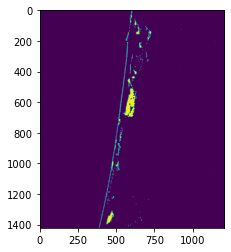

In [71]:
classified = np.where(band_1 > threshold, 1, 0)
plt.imshow(classified)

This looks a bit more realistic. We can now compute the area of the image that is sand. 

In [72]:
(np.sum(classified) / np.size(classified)) * 100

1.140428088411993

In [74]:
np.sum(classified)

19590